# Gaussian on TensorFlow

This notebook serves as a tutorial to implement Gaussian processes in TensorFlow 2.2 with TensorFlow Probability, a library for probabilistic reasoning and statistical analysis.

Ref: https://www.tensorflow.org/probability

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Statistics

1. `np.cov` uses the parameter `rowvar=0` to convert rows of samples into rows of variables to compute the covariance matrix.
2. `np.diag` obtains the diagonal, which is the variances from a covariance matrix.
3. `np.sqrt` will obtain the standard deviations of the diagonal.

In [2]:
X = np.array([[4.0, 2.0],
              [4.2, 2.1],
              [3.9, 2.0],
              [4.3, 2.1],
              [4.1, 2.2]])

X_mean = np.mean(X, axis=0)
X_cov = np.cov(X, rowvar=0)
X_diag = np.diag(X_cov)
X_stddev = np.sqrt(X_diag)

print(X_mean)
print(X_cov)
print(X_diag)
print(X_stddev)

[4.1  2.08]
[[0.025  0.0075]
 [0.0075 0.007 ]]
[0.025 0.007]
[0.15811388 0.083666  ]


# Multivariate Normal

1. `tfd.MultivariateNormalFullCovariance` will be deprecated and `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` should be used instead.
2. Cholesky decomposition of a positive definite matrix (e.g. covariance matrix) can be interpreted as "square root" of a positive definite matrix [1][2].

Ref:

* [1] http://www.seas.ucla.edu/~vandenbe/133A/lectures/chol.pdf

* [2] http://ais.informatik.uni-freiburg.de/teaching/ws12/mapping/pdf/slam05-ukf.pdf

In [3]:
mvn = tfd.MultivariateNormalFullCovariance(
    loc=X_mean,
    covariance_matrix=X_cov)

mvn_mean = mvn.mean().numpy()
mvn_cov = mvn.covariance().numpy()
mvn_stddev = mvn.stddev().numpy()

print(mvn_mean)
print(mvn_cov)
print(mvn_stddev)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
[4.1  2.08]
[[0.025  0.0075]
 [0.0075 0.007 ]]
[0.15811388 0.083666  ]


In [4]:
# Due to deprecated MultivariateNormalFullCovariance
mvn = tfd.MultivariateNormalTriL(
    loc=X_mean,
    scale_tril=tf.linalg.cholesky(X_cov))

mvn_mean = mvn.mean().numpy()
mvn_cov = mvn.covariance().numpy()
mvn_stddev = mvn.stddev().numpy()

print(mvn_mean)
print(mvn_cov)
print(mvn_stddev)

[4.1  2.08]
[[0.025  0.0075]
 [0.0075 0.007 ]]
[0.15811388 0.083666  ]


In [5]:
mvn = tfd.MultivariateNormalDiag(
    loc=X_mean,
    scale_diag=X_stddev)

mvn_mean = mvn.mean().numpy()
mvn_cov = mvn.covariance().numpy()
mvn_stddev = mvn.stddev().numpy()

print(mvn_mean)
print(mvn_cov)
print(mvn_stddev)

[4.1  2.08]
[[0.025 0.   ]
 [0.    0.007]]
[0.15811388 0.083666  ]


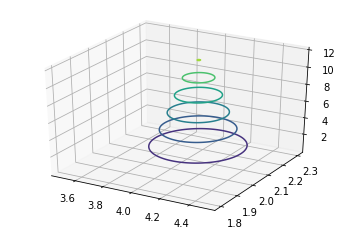

In [6]:
x = np.linspace(3.5, 4.5, 100)
y = np.linspace(1.8, 2.3, 100)
x, y = np.meshgrid(x, y)

data = np.stack((x.flatten(), y.flatten()), axis=1)
prob = mvn.prob(data).numpy()

ax = plt.axes(projection='3d')
plt.contour(x, y, prob.reshape((100, 100)));
# ax.plot_surface(x, y, prob.reshape((100,100)), cmap='viridis');

# Mixture of Gaussians

1. A categorical distribution `tfd.Categorical(probs=pi)` is a discrete probability distribution that models a random variable that takes 1 of K possible categories.
2. `tfd.MixtureSameFamily` allows definition of mixture models of the same family distribution without a for-loop.

In [7]:
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([10, 20, 30], dtype=np.float32)
sigma = np.array([1, 2, 3], dtype=np.float32)

23.0


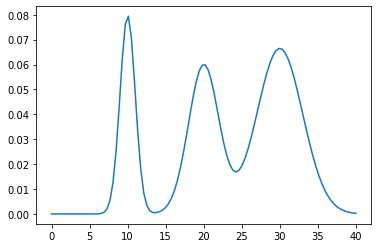

In [8]:
gmm = tfd.Mixture(
    cat=tfd.Categorical(probs=pi),
    components=[tfd.Normal(loc=m, scale=s) for m, s in zip(mu, sigma)]
)

x = np.linspace(0, 40, 100)
plt.plot(x, gmm.prob(x).numpy());

print(gmm.mean().numpy())

In [9]:
gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.Normal(loc=mu, scale=sigma)
)

print(gmm.mean().numpy())

23.0


# Multivariate Mixture of Gaussians

1. Multivariate Gaussian mixture models can be implemented in TensorFlow by combining `tfd.MixtureSameFamily` with `tfd.MultivariateNormalDiag`.

In [24]:
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([[10, 10],
               [20, 20],
               [30, 30]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)

In [25]:
mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

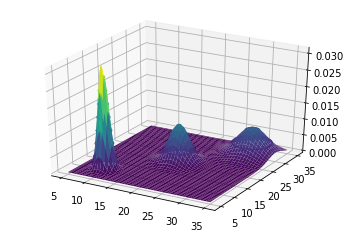

In [26]:
x = np.linspace(5, 35, 100)
y = np.linspace(5, 35, 100)
x, y = np.meshgrid(x, y)

data = np.stack((x.flatten(), y.flatten()), axis=1)
prob = mvgmm.prob(data).numpy()

ax = plt.axes(projection='3d')
plt.contour(x, y, prob.reshape((100, 100)));
ax.plot_surface(x, y, prob.reshape((100,100)), cmap='viridis');

# Conditional Multivariate Normal

In [13]:
def invert_indices(n_features, indices):
    inv = np.ones(n_features, dtype=np.bool)
    inv[indices] = False
    inv, = np.where(inv)
    return inv

In [14]:
# Scipy
class ConditionalMultivariateNormal(tfd.MultivariateNormalTriL):
    def parameters(self):
        covariances = self.covariance().numpy()
        means = self.loc.numpy()
        return means, covariances
    
    def condition(self, i2, x):
        _mu, _sigma = self.parameters()
        
        i1 = invert_indices(_mu.shape[0], indices)

        cov_12 = _sigma[np.ix_(i1, i2)]
        cov_11 = _sigma[np.ix_(i1, i1)]
        cov_22 = _sigma[np.ix_(i2, i2)]
        prec_22 = scipy.linalg.pinvh(cov_22)  # precision = inverse covariance
        regression_coeffs = cov_12.dot(prec_22)

        mean = _mu[i1] + regression_coeffs.dot((x - _mu[i2]).T).T
        covariance = cov_11 - regression_coeffs.dot(cov_12.T)
        return ConditionalMultivariateNormal(loc=mean,
                                      scale_tril=tf.linalg.cholesky(covariance))
    def marginalize(self, indices):
        _mu, _sigma = self.parameters()
        return ConditionalMultivariateNormal(loc=_mu[indices],
                                          scale_tril=tf.linalg.cholesky(
                                              _sigma[np.ix_(indices, indices)]))

In [15]:
# Tensorflow
class ConditionalMultivariateNormal(tfd.MultivariateNormalTriL):
    def parameters(self):
        covariances = self.covariance()
        means = self.loc
        return means, covariances
    
    def condition(self, i2, x):
        _mu, _sigma = self.parameters()
        
        i1 = invert_indices(_mu.shape[0], indices)
        
        cov_12 = tf.gather(tf.gather(_sigma, i1, axis=0), i2, axis=1)
        cov_11 = tf.gather(tf.gather(_sigma, i1, axis=0), i1, axis=1)
        cov_22 = tf.gather(tf.gather(_sigma, i2, axis=0), i2, axis=1)
        
        prec_22 = tf.linalg.pinv(cov_22)  # TODO: check pinv vs pinvh
        regression_coeffs = tf.tensordot(cov_12, prec_22, axes=1)  # TODO: axes
        
        mean = tf.gather(_mu, i1, axis=0)  # TODO: axes
        diff = tf.transpose(x - tf.gather(_mu, i2, axis=0))  # TODO: axes
        mean += tf.transpose(tf.tensordot(regression_coeffs, diff, axes=1))  # TODO: axes
        
        covariance = cov_11 - tf.tensordot(regression_coeffs, tf.transpose(cov_12), axes=0)
        return ConditionalMultivariateNormal(loc=mean,
                                      scale_tril=tf.linalg.cholesky(covariance))
    def marginalize(self, indices):
        _mu, _sigma = self.parameters()
        return ConditionalMultivariateNormal(loc=_mu.numpy()[indices],
                                          scale_tril=tf.linalg.cholesky(
                                              _sigma.numpy()[np.ix_(indices, indices)]))

In [17]:
# Conditional Distribution P(X1|X0)
mvn = ConditionalMultivariateNormal(
    loc=X_mean,
    scale_tril=tf.linalg.cholesky(X_cov))

x = np.array([2])
indices = np.array([1])

conditional_mvn = mvn.condition(indices, x)
marginal_mvn = mvn.marginalize(indices)

print(conditional_mvn.sample().numpy())
print(marginal_mvn.sample().numpy())

[[[4.22080721]]]
[2.07630817]


# Conditional Multivariate Mixture of Gaussians

In [19]:
# Scipy
class GaussianMixture(tfd.MixtureSameFamily):
    def parameters(self):
        _pi = self.mixture_distribution.probs.numpy()
        _mu = self.components_distribution.loc.numpy()
        _sigma = self.components_distribution.scale_tril.numpy()
        return _pi, _mu, _sigma
    
    def condition(self, indices, x):
        _pi, _mu, _sigma = self.parameters()
        
        n_features = _mu.shape[1] - indices.shape[0]
        n_components = _pi.shape[0]
        
        priors = np.empty(n_components)
        means = np.empty((n_components, n_features))
        covariances = np.empty((n_components, n_features, n_features))
        for k in range(n_components):
            mvn = ConditionalMultivariateNormal(loc=_mu[k],
                                         scale_tril=_sigma[k])
            conditioned = mvn.condition(indices, x)
            __mu, __sigma = conditioned.parameters()
            priors[k] = mvn.marginalize(indices).prob(x).numpy()
            means[k] = __mu
            covariances[k] = __sigma
        priors /= priors.sum()
        
        return GaussianMixture(
            mixture_distribution=tfd.Categorical(probs=priors),
            components_distribution=ConditionalMultivariateNormal(loc=means,
                                                           scale_tril=tf.linalg.cholesky(covariances))
        )
    
    def marginalize(self, indices):
        _pi, _mu, _sigma = self.parameters()
        return GaussianMixture(
            mixture_distribution=tfd.Categorical(probs=_pi),
            components_distribution=ConditionalMultivariateNormal(loc=_mu[:,indices],
                                                                 scale_tril=_sigma[np.ix_(np.ones(_sigma.shape[0], dtype=np.bool), indices, indices)])
        )

In [22]:
# Tensorflow
class GaussianMixture(tfd.MixtureSameFamily):
    def parameters(self):
        _pi = self.mixture_distribution.probs
        _mu = self.components_distribution.loc
        _sigma = self.components_distribution.scale_tril
        return _pi, _mu, _sigma
    
    def condition(self, indices, x):
        _pi, _mu, _sigma = self.parameters()
        
        n_features = _mu.shape[1] - indices.shape[0]
        n_components = _pi.shape[0]
        
        priors = []
        means = []
        covariances = []
        
#         priors = np.empty(n_components)
#         means = np.empty((n_components, n_features))
#         covariances = np.empty((n_components, n_features, n_features))
        for k in range(n_components):
            mvn = ConditionalMultivariateNormal(loc=_mu[k],
                                         scale_tril=_sigma[k])
            conditioned = mvn.condition(indices, x)
            __mu, __sigma = conditioned.parameters()
            
            priors.append(mvn.marginalize(indices).prob(x))
            means.append(__mu)
            covariances.append(__sigma)
            
        priors = tf.stack(priors)
        means = tf.stack(means)
        covariances = tf.stack(covariances)
        
        priors /= tf.reduce_sum(priors)  # division
        
        return GaussianMixture(
            mixture_distribution=tfd.Categorical(probs=priors),
            components_distribution=ConditionalMultivariateNormal(loc=means,
                                                           scale_tril=tf.linalg.cholesky(covariances))
        )
    
    def marginalize(self, indices):  # TODO: Indexing in TF
        _pi, _mu, _sigma = self.parameters()
        return GaussianMixture(
            mixture_distribution=tfd.Categorical(probs=_pi),
            components_distribution=ConditionalMultivariateNormal(loc=_mu[:,indices],
                                                                 scale_tril=_sigma[np.ix_(np.ones(_sigma.shape[0], dtype=np.bool), indices, indices)])
        )

In [23]:
pi.shape, mu.shape, sigma.shape

((3,), (3, 2), (3, 2))

In [20]:
# Generate known parameters of a multivariate mixture of Gaussians
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([[10, 20],
               [15, 25],
               [20, 30]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)

mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

# Manually generate covariance
cov = mvgmm.components_distribution.covariance().numpy().astype(np.float64)

# Conditional MVGMM
mvgmm = GaussianMixture(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalTriL(
        loc=mu.astype(np.float64),
        scale_tril=tf.linalg.cholesky(cov.astype(np.float64)))
)

In [21]:
# Conditional distribution P(X1|X0)
x = np.array([20])
indices = np.array([0])

conditional_mvgmm = mvgmm.condition(indices, x)
print(conditional_mvgmm.sample().numpy())

[24.81595828]


In [22]:
# Marginal distribution P(X0)
indices = np.array([0])
marginal_mvgmm = mvgmm.marginalize(indices)
print(marginal_mvgmm.sample().numpy())

[11.81237066]
